LOUVAT Charles 

MOHAMED Ben-Hazem

github : https://github.com/carloslvt

----

Avant toutes analyses, importons les données :

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('diabetes.csv', sep = ",")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Nous avons un dataset comportant des données sur :

- le nombre de grossesses
- le taux de glucose
- la tension artérielle 
- l'épaisseur de la peau
- le taux d'insuline
- l'IMC
- les antécédents familiaux
- l'âge
- les résultats (diabétique ou non)

La target de ce dataset est donc la variable "Outcome", qui désigne si le patient est diabétique ou non. 

Commençons les analyses.

# Exploratory Data Analysis


## Analyse de la forme des données

In [3]:
df = data.copy()
df.shape

(768, 9)

Nous avons ici 9 variables, comportant chacune 768 données.

Regardons de quel type sont ces données :

<AxesSubplot:ylabel='None'>

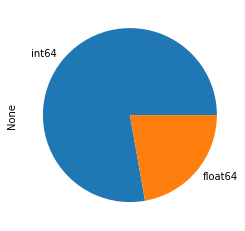

In [4]:
df.dtypes.value_counts().plot.pie()

Dans ce dataset, nous avons principalement des données de type "int" (des entiers) à 75% et 25% de "float" (nombre à virgule).

Vérifions maintenant les données manquantes :

<AxesSubplot:>

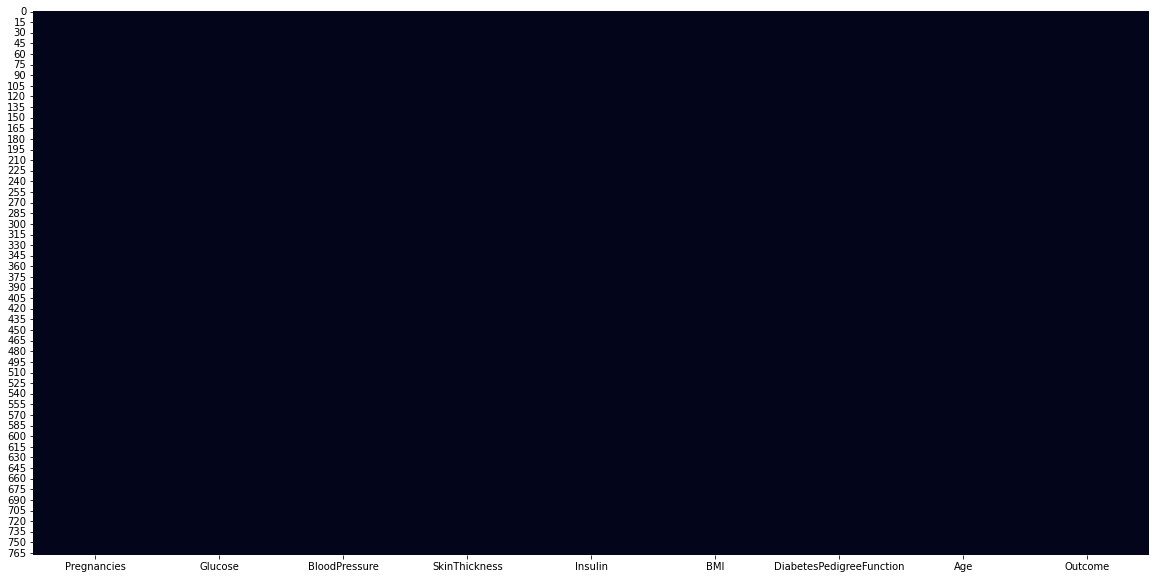

In [5]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

In [6]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=True)

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
Outcome                     0.0
dtype: float64

Bonne nouvelle, nous n'avons aucune donnée manquante.

## Analyse du Fond
### Examen de la colonne target

In [8]:
df['Outcome'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

Nous avons donc 65% des patients négatifs au diabète.

### Histogrames des variables quantitatives

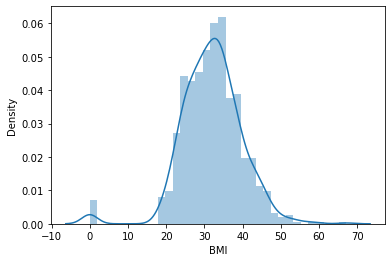

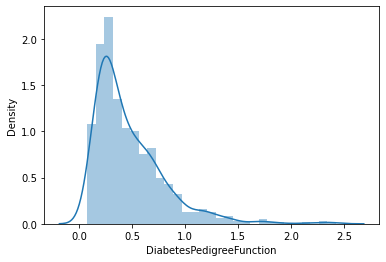

In [11]:
for col in df.select_dtypes('float'):
    plt.figure()
    sns.distplot(df[col])

Nous pouvons voir que la majorité des patients ont un IMC entre 30 et 40 (obèse) et n'ont pas ou peu d'antécédents familiaux.

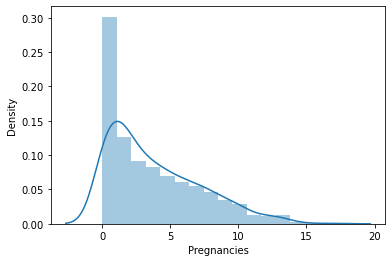

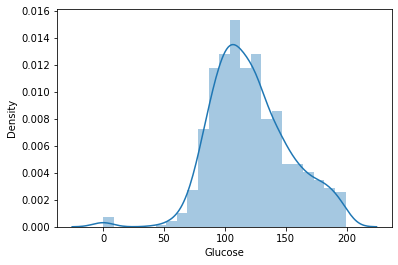

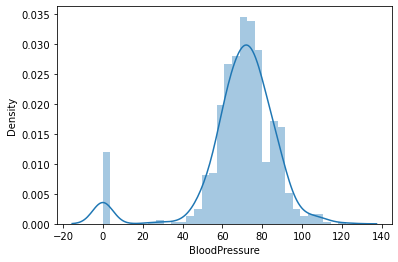

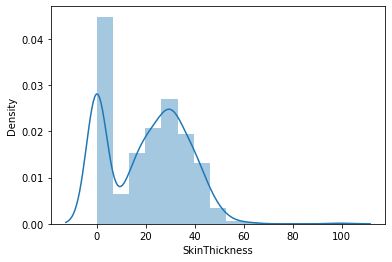

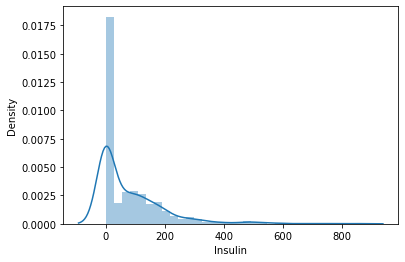

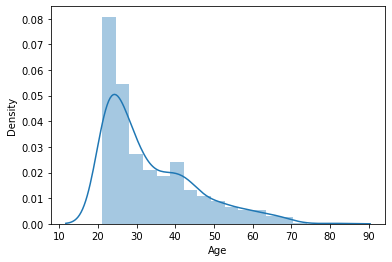

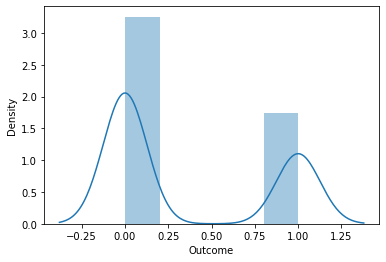

In [12]:
for col in df.select_dtypes('int'):
    plt.figure()
    sns.distplot(df[col])

Nous pouvons voir que l'âge moyen des patients est entre 20 et 30ans et qu'ils semblent avoir une tension artérielle correcte. Cependant, nous pouvons voir de nombreuses valeurs à 0 pour la tension artérielle et l'épaisseur de la peau qui semblent être des valeurs manquantes.

De plus, nous pouvons voir plusieurs patients avec un taux d'insuline nul, il serait intéressant de voir si cela est corrélé au patient diabétique.

## Relation Target / Variables
### Création de sous-ensembles positifs et négatifs

In [19]:
positive_df = df[df['Outcome'] == 1]
negative_df = df[df['Outcome'] == 0]

### Target / int

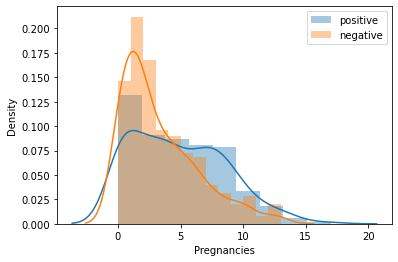

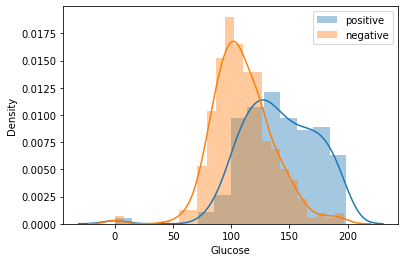

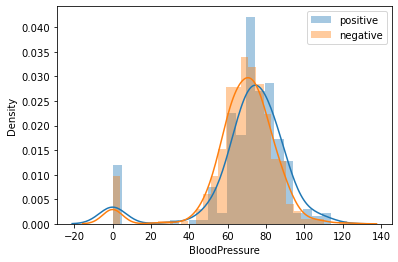

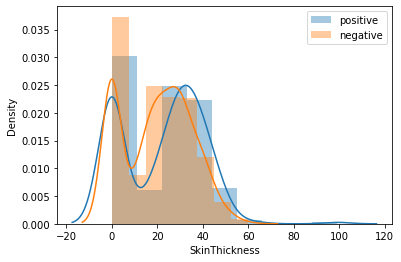

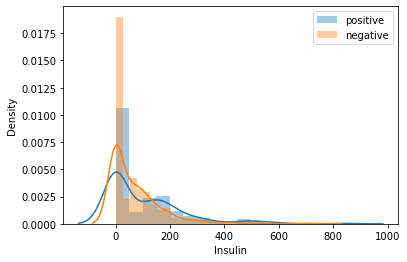

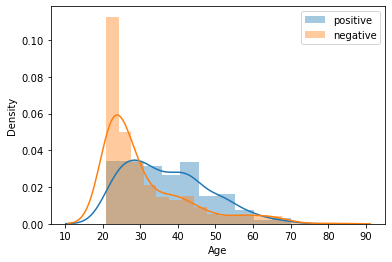

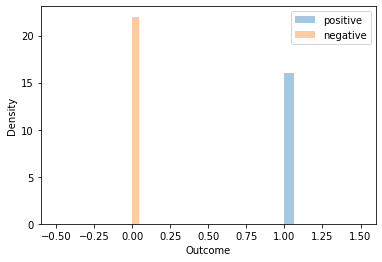

In [20]:
for col in df.select_dtypes('int'):
    plt.figure()
    sns.distplot(positive_df[col], label='positive')
    sns.distplot(negative_df[col], label='negative')
    plt.legend()

Nous pouvons voir que les personnes diabétiques sont généralement plus vieilles et ont un taux de glucose plus élevé que les autres.

### Target / float

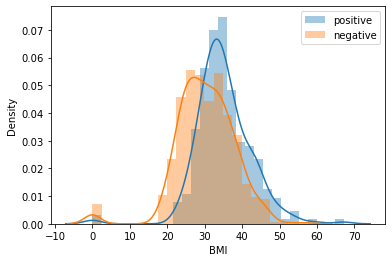

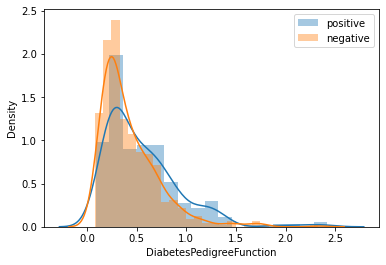

In [22]:
for col in df.select_dtypes('float'):
    plt.figure()
    sns.distplot(positive_df[col], label='positive')
    sns.distplot(negative_df[col], label='negative')
    plt.legend()

On dirait que les personnes diabétiques ont un IMC plus élevés que les autres.

## Analyse un peu plus Avancée

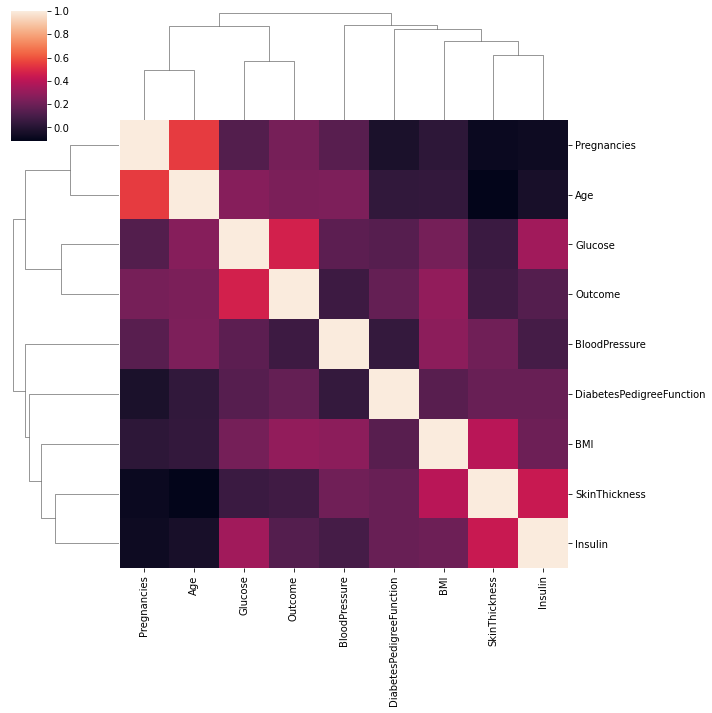

In [26]:
sns.clustermap(df.corr())

Il semble y avoir des corrélations entre l'âge et le nombre de grossesse, entre le diabétique et le taux de glucose ainsi qu'entre l'épaisseur de la peau et le taux d'insuline.

Maintenant, nous pouvons passer au pre-processing.

# Pre-processing

Dans un premier temps, nous allons remplacer les valeurs à 0 par la médiane.

In [27]:
df['SkinThickness'] = df['SkinThickness'].replace(0, df['Insulin'].median())
df['BloodPressure'] = df['BloodPressure'].replace(0, df['BloodPressure'].median())
df['BMI'] = df['BMI'].replace(0, df['BMI'].median())

Nous pouvons maintenant séparer notre target des autres variables

In [30]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

print(y.value_counts())

0    500
1    268
Name: Outcome, dtype: int64


Nous pouvons maintenant passer à la modélisation.

# Méthodes d’agrégation

Les méthodes ensemblistes (ou d’agrégation) pour les algorithmes d’apprentissage statistique (en anglais : ensemble learning) sont basées sur l’idée de combiner les prédictions de plusieurs prédicteurs (ou classifieurs) pour une meilleure généralisation et pour compenser les défauts éventuels de prédicteurs individuels.

En général, on distingue deux familles de méthodes de ce type :

1. Méthodes par moyennage (bagging, forêts aléatoires) où le principe est de faire la moyenne de plusieurs prédictions en espérant un meilleur résultat suite à la réduction de variance de l’éstimateur moyenne.
2. Méthodes adaptatives (boosting) où les paramètres sont itérativement adaptés pour produire un meilleur mélange.

Dans la suite nous explorerons chacune de ces classes d’algorithme en Scikit-learn et présenterons quelques comparaisons.

# Bagging

Les méthodes de type bagging construisent plusieurs instances d’un estimateur, calculées sur
des échantillons aléatoires tirés de la base d’apprentissage (et éventuellement une partie des
attributs, également sélectionnés de façon aléatoire), et ensuite combine les prédictions
individuelles en réalisant leur moyenne pour réduire la variance de l’estimateur. Leur avantage
principal réside dans le fait qu’ils construisent une version améliorée de l’algorithme de base,
sans demander de modification de cet algorithme. Le prix à payer est un coût de calcul plus
élevé. Comme elles réduisent le sur-apprentissage, les méthodes bagging fonctionnent très
bien avec des prédicteurs « forts ». Par contraste, les méthodes boosting sont mieux adaptées
à des prédicteurs faibles (weak learners).

Dans Scikit-learn, les méthodes de bagging sont implémentées via la
classe BaggingClassifier et BaggingRegressor. Les constructeurs prennent en paramètres un
estimateur de base et la stratégie de sélection des points et attributs :

- base_estimator : optionnel (default=None). Si None alors l’estimateur est un arbre de décision.
- max_samples : la taille de l’échantillon aléatoire tiré de la base d’apprentissage.
-  max_features : le nombre d’attributs tirés aléatoirement.
- bootstrap : boolean, optionnel (default=True). Tirage des points avec remise ou non.
- bootstrap_features : boolean, optionnel (default=False). Tirage des attributs avec remise ou non.
- oob_score : boolean. Estimer ou non l’erreur de généralisation OOB (Out of Bag).

Le code suivant construit un ensemble des classifieurs. Chaque classifieur de base est
un KNeighborsClassifier (c’est-à-dire k-plus-proches-voisins), chacun utilisant au maximum
50% des points pour son apprentissage et la moitié des attributs (features) :

In [32]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5,
max_features=0.5)

Pour ce TP, nous allons utiliser comme classifieur de base un arbre de
décision DecisionTreeClassifier. Ce classifieur nous permet d’établir des performances de
référence (c’est un ensemble à 1 modèle).

In [33]:
import numpy as np
from sklearn import tree
from sklearn.ensemble import BaggingClassifier

clf = tree.DecisionTreeClassifier()
clf.fit(X, y)
accuracy = clf.score(X, y)
print(accuracy)

1.0


Sur la base d’apprentissage accuracy = 1 . Pour plus de réalisme, découpons la base de données en un jeu d’apprentissage et un jeu de test afin de voir le comportement de généralisation de l’arbre sur des données différentes de celles d’apprentissage :

In [34]:
from sklearn.model_selection import train_test_split

# 90% des données pour le test, 10% pour l'apprentissage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

Z = clf.predict(X_test)
accuracy = clf.score(X_test,y_test)
print(accuracy)

0.7239884393063584


**Question :**

**Construire la variance de la valeur accuracy sur 100 tirages pour la séparation apprentissage/test. Que pouvons-nous conclure ?**

In [35]:
import pandas as pd

score = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90)
    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    Z = clf.predict(X_test)
    score.append(clf.score(X_test,y_test))

mean = np.mean(score)
std = np.std(score)
res = [{'Moyenne':mean, 'Ecart-type':std}]
df = pd.DataFrame(res)
print(df)

    Moyenne  Ecart-type
0  0.674408    0.028733


Nous pouvons voir qu'avec 100 tirages, on obtient une moyenne de 67% et un écart-type de 2,8% pour l'accuracy. La variance est donc relativement faible.

Pour comparer, construisons mainntenant un classifieur bagging sur nos données, toujours
basé sur les DecisionTreeClassifier :

In [36]:
clf = BaggingClassifier(tree.DecisionTreeClassifier(),
                        max_samples=0.5, max_features=0.5, n_estimators=200)

L’apprentissage et l’évaluation de cet ensemble se font de la façon habituelle :

In [37]:
clf.fit(X_train, y_train)
Z = clf.predict(X_test)
accuracy=clf.score(X_test,y_test)

**Question :**

**Calculer la variance de la valeur accuracy sur 100 tirages pour la séparation apprentissage/test.
Comparer avec la variance du classifieur de base. Que pouvons-nous conclure ?**

In [38]:
score = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90)
    clf = BaggingClassifier(tree.DecisionTreeClassifier(),
                        max_samples=0.5, max_features=0.5, n_estimators=200)
    clf.fit(X_train, y_train)
    Z = clf.predict(X_test)
    score.append(clf.score(X_test,y_test))

mean = np.mean(score)
std = np.std(score)
res = [{'Moyenne':mean, 'Ecart-type':std}]
df = pd.DataFrame(res)
print(df)

    Moyenne  Ecart-type
0  0.727991    0.023731


Ici, nous pouvons remarquer que la moyenne est beaucoup plus élevée qu'avec un simple arbre de décision. De plus, nous pouvons voir que la variance est, quant à elle, plus faible que la version précédente. Pour conclure, l'utilisation du bagging permet d'avoir un classifieur beaucoup plus stable.

**Question :**

**Construire le graphique accuracy vs n_estimators. Que constatez-vous ?** 

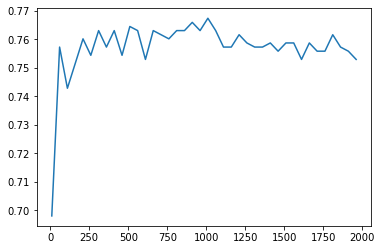

In [39]:
accuracy = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)

for i in range(10, 2000, 50):
    clf = BaggingClassifier(tree.DecisionTreeClassifier(), max_samples=0.5, max_features=0.5, n_estimators=i)
    clf.fit(X_train, y_train)
    Z = clf.predict(X_test)
    accuracy.append(clf.score(X_test,y_test))

plt.plot([i for i in range(10, 2000, 50)], accuracy)
plt.show()

Ici, nous avons réalisé un graphique avec un n_estimators allant 10 à 2000 avec un pas de 50 afin de voir le nombre optimal de n_estimators. C'est-à-dire, l'endroit où la courbe d'accuracy se stabilise.

En visualisant le graphique, nous pouvons remarquer que la courbe se stabilise aux alentours des 250 n_estimators pour un accuracy de 0.76. Il sera donc inutile de rajouter plus d'arbre.

**Question :**

**Faites varier les parametres max_samples et max_features. Pour quelles valeurs on obtient le
meilleur résultat ? On pourra notamment utiliser GridSearchCV pour réaliser une recherche
systématique.**

In [40]:
from sklearn.model_selection import GridSearchCV

pgrid = {"max_samples": [i for i in np.arange(0.2,1.0,0.2)],
        "max_features": [i for i in np.arange(0.2,1.0,0.2)]}

grid_search = GridSearchCV(BaggingClassifier(tree.DecisionTreeClassifier()), param_grid=pgrid, cv=5)
grid_search.fit(X_train, y_train)

print("Meilleur score : " + str(grid_search.best_estimator_.score(X_test, y_test)))
print("Meilleurs paramètres: " + str(grid_search.best_params_))

Meilleur score : 0.7297687861271677
Meilleurs paramètres: {'max_features': 0.8, 'max_samples': 0.4}


Dans cette question, nous avons fait varier les paramètres max_samples et max_features de 0.2 à 1 avec un pas de 0.2. Nous pouvons voir que nous obtenons le meilleur résultat (0.73) avec un max_features = 0.8, et un max_samples = 0.4.

# Forêts aléatoires

L’algorithme des forêts aléatoires propose une optimisation des arbres de décision. Il utilise le
même principe que le bagging, mais avec une étape supplémentaire de randomisation dans
la sélection des attributs des nœuds dans le but de réduire la variance de l’estimateur obtenu.

Les deux objets Python qui implémentent les forêts aléatoires
sont RandomForestClassifier et RandomForestRegressor.
Les paramètres les plus importants sont :

- n_estimators : integer, optional (default=10). Le nombre d’arbres.
- max_features : le nombre d’attributs à considérer à chaque split.
- max_samples : la taille de l’échantillon aléatoire tiré de la base d’apprentissage.
- min_samples_leaf : le nombre minimal d’éléments dans un nœud feuille.
- oob_score : boolean. Estimer ou non l’erreur de généralisation OOB (Out of Bag).

Par la suite nous allons refaire la classification sur la base Digits en utilisant un
classifieur RandomForestClassifier. Comme d’habitude, on sépare les données en gardant 10%
pour l’apprentissage et 90% pour le test.

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90)

On peut désormais créer et entraîner notre modèle :

In [42]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

Puis réaliser les prédictions et calculer le score de test :

In [43]:
y_pred = clf.predict(X_test)
accuracy = clf.score(X_test,y_test)
print(accuracy)

0.7673410404624278


**Question :**

**Comment la valeur de la variable accuracy se compare avec le cas bagging qui utilise le même
nombre d’arbres (200 dans notre cas) ?**

In [44]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
Z = clf.predict(X_test)
print(f"Arbre de décision : {round(clf.score(X_test,y_test),3)}")

clf = BaggingClassifier(tree.DecisionTreeClassifier(), max_samples=0.5, max_features=0.5, n_estimators=200)
clf.fit(X_train, y_train)
Z = clf.predict(X_test)
print(f"Bagging: {round(clf.score(X_test,y_test),3)}")

clf = RandomForestClassifier(n_estimators=200)
clf.fit(X_train, y_train)
Z = clf.predict(X_test)
print(f"Forêt aléatoire: {round(clf.score(X_test,y_test),3)}")

Arbre de décision : 0.698
Bagging: 0.759
Forêt aléatoire: 0.76


Nous pouvons remarquer que nous obtenons des meilleurs résultats avec les cas de bagging (BaggingClassifier, RandomForestClassifier) qu'avec un arbre de décision. Et entre les deux cas de bagging, nous obtenons un meilleur résultat avec la forêt aléatoire (très légère). En effet, la forêt aléatoire est plus optimisée que le BaggingClassifier.

**Question :**

**Construire la variance de la valeur accuracy sur 100 tirages pour la séparation
apprentissage/test. Que pouvons-nous conclure en comparant avec la séction précedente
(bagging) ?**

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)

bagging_score = []
for i in range(100):
    clf = BaggingClassifier(tree.DecisionTreeClassifier(), n_estimators=200)
    clf.fit(X_train, y_train)
    bagging_score.append(clf.score(X_test,y_test))

rf_score = []
for i in range(100):
    clf = RandomForestClassifier(n_estimators=200)
    clf.fit(X_train, y_train)
    rf_score.append(clf.score(X_test,y_test))

    
mean_bagging, std_bagging = np.mean(bagging_score), np.std(bagging_score)
mean_rf, std_rf = np.mean(rf_score), np.std(rf_score)

ar = np.array([[mean_bagging, std_bagging], [mean_rf,std_rf]])
df = pd.DataFrame(ar, index = ['Bagging', 'RandomForest'], columns = ['Moyenne', 'Ecart-type'])
print(df)

               Moyenne  Ecart-type
Bagging       0.714538    0.006779
RandomForest  0.722413    0.007763


Après avoir construit la variance de la valeur accuracy sur 100 tirages pour le bagging et la forêt aléatoire, on constate que la forêt aléatoire est meilleure que le bagging avec un accuracy de 0.72 et une variance de 0.008, alors que le bagging n'obtient qu'un accuracy de 0.71 mais une variance légèrement plus faible 0.007. La forêt aléatoire est donc plus stable que le bagging et obtient un meilleur score.

**Question :**

**Construire le graphique accuracy vs n_estimators. Que constatez-vous ? A partir de quelle valeur
on n’améliore plus ?**

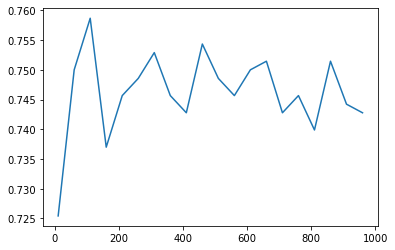

In [46]:
accuracy = []

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)

for i in range(10, 1000, 50):
    clf = RandomForestClassifier(n_estimators=i)
    clf.fit(X_train, y_train)
    accuracy.append(clf.score(X_test,y_test))
#     print(i, accuracy[i])

plt.plot([i for i in range(10, 1000, 50)], accuracy)
plt.show()

Pour construire ce graphique, nous avons fait varier n_estimators de 10 à 1000 avec un pas de 50. Nous pouvons constater que le nombre d'arbres de la forêt aléatoire influence l'accuracy, plus il y a d'arbres plus l'accuracy augmente, jusqu'à que celui-ci se stabilise. Ici, la valeur ne s'améliore plus à partir de n_estimators = 150.

**Question :**

**Regardez dans la documentation les ExtraTreesClassifier et refaites la classification avec ce
type de classifieur. Comparez avec RandomForestClassifier.**

ExtraTreesClassifier est une méthode d'apprentissage d'ensemble basée fondamentalement sur les arbres de décision. 

Extra Trees ressemble à Random Forest, en ce sens qu'il construit plusieurs arbres et divise les nœuds à l'aide de sous-ensembles aléatoires de caractéristiques, mais avec deux différences essentielles : il n'effectue pas de bootstrap des observations (ce qui signifie qu'il échantillonne sans remplacement), et les nœuds sont divisés sur des divisions aléatoires, et non sur les meilleures divisions. 


In [47]:
from sklearn.ensemble import ExtraTreesClassifier

clf = RandomForestClassifier(n_estimators = 200)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(f"Forêt aléatoire : {round(accuracy, 3)}")

clf = ExtraTreesClassifier(n_estimators=200)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test,y_test)
print(f"Extra Trees : {round(accuracy, 3)}")

Forêt aléatoire : 0.747
Extra Trees : 0.747


Nous pouvons voir que l'ExtraTreesClassifier obtient un score identique que la forêt aléatoire.

# Boosting

Le principe du boosting est d’évaluer une séquence de classifieurs faibles (weak learners) sur
plusieurs versions légèrement modifiées des données d’apprentissage. Les décisions
obtenues sont alors combinées par une somme pondérée pour obtenir le modèle final.
Avec scikit-learn, c’est la classe AdaBoostClassifier qui implémente cet algorithme. Les
paramètres les plus importants sont :

- n_estimators : integer, optional (default=10). Le nombre de classifieurs faibles.
- learning_rate : contrôle la vitesse de changement des poids par itération.
- base_estimator : (default=DecisionTreeClassifier) le classifieur faible utilisé.

Dans la suite nous allons refaire la classification sur la base Digits en utilisant un
classifieur RandomForestClassifier :

In [48]:
from sklearn.ensemble import AdaBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.90)

# AdaBoost basé sur 200 arbres de décision
clf = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth = 5),
n_estimators = 200, learning_rate = 2)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.7341040462427746


**Question :**

**Le paramètre max_depth contrôle la profondeur de l’arbre. Essayez plusieurs valeurs pour voir
l’impact de l’utilisation d’un classifieur faible vs plus fort (max_depth élevé ou éliminer le
paramètre). Testez aussi l’effet du paramètre learning_rate et le nombre de classifieurs.**

In [49]:
score_md = list()
score_lr = list()
score_ne = list()

for i in range(2,11, 2):
    clf = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth = i))
    clf = clf.fit(X_train, y_train)
    score_md.append({'max_depth': i, 'score': clf.score(X_test, y_test)})

for i in np.arange(0.2, 2, 0.2):
    clf = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(), learning_rate = i)
    clf = clf.fit(X_train, y_train)
    score_lr.append({'learning_rate': i, 'score': clf.score(X_test, y_test)})

for i in range(200, 1001, 200):
    clf = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(), n_estimators = i)
    clf = clf.fit(X_train, y_train)
    score_ne.append({'n_estimators': i, 'score': clf.score(X_test, y_test)})

In [50]:
df1 = pd.DataFrame(score_md)
df2 = pd.DataFrame(score_lr)
df3 = pd.DataFrame(score_ne)

print(df1,"\n\n", df2, "\n\n", df3)

   max_depth     score
0          2  0.731214
1          4  0.736994
2          6  0.673410
3          8  0.669075
4         10  0.656069 

    learning_rate     score
0            0.2  0.666185
1            0.4  0.669075
2            0.6  0.657514
3            0.8  0.673410
4            1.0  0.660405
5            1.2  0.663295
6            1.4  0.651734
7            1.6  0.660405
8            1.8  0.661850 

    n_estimators     score
0           200  0.669075
1           400  0.673410
2           600  0.661850
3           800  0.658960
4          1000  0.667630


Nous pouvons voir qu'un max_depth faible génère des arbres peu profonds qui ont tendance à trop généraliser (sous-apprentissage). Alors qu'un max_depth élevé génère des arbres trop profonds et donc pas assez généralisé (sur-apprentissage), il faut donc trouver le juste milieu. Ici, une max_depth à 4 semble obtenir le meilleur score.

Cependant, un max_depth faible (par exemple max_depth = 2) peut être compensé par un paramètre n_estimators plus grand.

Une valeur plus faible de learning_rate permet d’améliorer le score, mais pas au-delà d’une certaine valeur.

# Conclusion

Dans ce TP nous avons pu voir les différentes méthodes d'agrégation  de l'arbre de décision(Bagging, Forêts Aléatoires et le boosting) et les comparer. Nous avons commencé avec la méthode de bagging :

La technique bagging réduit le surajustement du modèle. Il fonctionne également bien sûr des données de grandes dimensions. De plus, les valeurs manquantes dans le jeu de données n'affectent pas les performances de l'algorithme.

Ensuite nous avons vu la méthode de foret aléatoire. Nous pouvons constater que les Forêts Aléatoires ont un nombre de propriétés qui font d’eux un outil précieux, surtout quand il s’agit de faire l’analyse rapide d’un jeu de données ou d’élaborer un prototype de classifieur. Cette méthode donne en général de meilleur résultat que le bagging puisqu'elle est plus optimisée.

Pour finir, nous avons vu la méthode de boosting avec la fonction AdaBoost. Adaboost utilise des souches (arbre de décision avec un seul découpage). Ainsi, Adaboost est essentiellement une forêt de souches. Ces souches sont appelées apprenants faibles. Ces apprenants faibles ont un biais élevé et une faible variance.



